In [13]:
%matplotlib inline

In [14]:
import itertools
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_bids

In [15]:
ROOT = Path("../data/MASC-MEG")

In [16]:
phoneme_info = pd.read_csv(ROOT / "phoneme_info.csv")
phoneme_list = phoneme_info.phoneme.tolist()

In [17]:
class Parameters(dict):

    def __getattr__(self, attr):
        try:
            if isinstance(self[attr], dict):
                return Parameters(**self[attr])
            return self[attr]
        except KeyError:
            raise AttributeError(attr)
        
    def __getitem__(self, item):
        if item in self:
            if isinstance(self.get(item), dict):
                return Parameters(**self.get(item))
            return self.get(item)
        else:
            raise KeyError(item)

    def __repr__(self):
        return "Parameters " + super(Parameters, self).__repr__()

    def __str__(self):
        return "Parameters " + super(Parameters, self).__str__()

In [18]:
P = Parameters(
    bandpass=dict(high=30.0, low=0.5),
    scaler="RobustScaler",
    scaler_params=dict(q1=25.0, q3=75.0),
    seed=42,
    epochs=dict(decim=5, tmin=-0.5, tmax=3.0, baseline=(-0.5, 0.0)),
    sampling_rate=1000,
    )

In [19]:
def get_epochs(subject, level="all"):
    all_w_epochs, all_ph_epochs = list(), list()
    for session, task in itertools.product(range(1), range(1)):
        print(f"Loading: sub{subject}-sess{session}-task{task}")

        bids_path = mne_bids.BIDSPath(
            subject=subject, 
            session=str(session), 
            task=str(task),
            datatype="meg",
            root=ROOT
        )

        try:
            raw = mne_bids.read_raw_bids(bids_path)
        except FileNotFoundError:
            print(f"Not found: sub{subject}-sess{session}-task{task}")
            continue

        raw = raw.pick_types(
            meg=True, misc=False, eeg=False, eog=False, ecg=False
        )

        raw.load_data().filter(
            P.bandpass.low, 
            P.bandpass.high, 
            n_jobs=1
        )

        annotations = preprocess_annotations(raw)

        w_epochs = ph_epochs = None
        if level in ["word", "all"]:
            words = annotations.query("kind=='word'")
            w_epochs = segment(raw, words)
            w_epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(w_epochs))
            ).astype(int)
            w_epochs.metadata["task"] = task
            w_epochs.metadata["session"] = session

            all_w_epochs.append(w_epochs)

        if level in ["phoneme", "all"]:
            phonemes = annotations.query("kind=='phoneme'")
            ph_epochs = segment(raw, phonemes)
            ph_epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(ph_epochs))
            ).astype(int)
            ph_epochs.metadata["task"] = task
            ph_epochs.metadata["session"] = session

            all_ph_epochs.append(ph_epochs)
    
    w_epochs = None
    if len(all_w_epochs) > 0:
        w_epochs = concatenate(all_w_epochs)
        
    ph_epochs = None
    if len(all_ph_epochs) > 0:
        ph_epochs = concatenate(all_ph_epochs)

    return w_epochs, ph_epochs, annotations

def concatenate(all_epochs):
    epochs = mne.concatenate_epochs(all_epochs)
    m = epochs.metadata
    label = (
        "t"
        + m.task.astype(str)
        + "_s"
        + m.session.astype(str)
        + "_h"
        + m.half.astype(str)
    )
    epochs.metadata["label"] = label

    return epochs
    
def preprocess_annotations(raw):
    df_raw = raw.annotations.to_data_frame()
    df_raw["onset"] = raw.annotations.onset
    df_desc = pd.DataFrame(df_raw.description.apply(eval).to_list())
    df = pd.concat([df_raw.drop("description", axis=1), df_desc], axis=1)
    
    df[["index", "subject"]] = df[["index", "subject"]].fillna(method="ffill")
    
    df_ = df.copy().query("kind != 'sound'")
    
    df_["word"] = df_["word"].shift(-1)
    df_filled = df_["word"].fillna(method="ffill")
    
    df.loc[df["kind"] != "sound", "word"] = df_filled
    
    def as_short_phoneme(x):
        if isinstance(x, str):
            return x.split("_")[0]
        return x
    
    def as_phoneme_code(x):
        if isinstance(x, str):
            return phoneme_list.index(x.split("_")[0])
        return x
    
    df["s_phoneme"] = df["phoneme"].apply(as_short_phoneme) 
    df["phoneme_code"] = df["phoneme"].apply(as_phoneme_code) 
    
    return df
    
def segment(raw, meta):
    events = np.c_[
        meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
    ].astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=P.epochs.tmin,
        tmax=P.epochs.tmax,
        decim=P.epochs.decim,
        baseline=P.epochs.baseline,
        metadata=meta,
        preload=True,
        event_repeated="drop",
    )
    
    return epochs

## Decoding task 2.1: MEG -> phoneme sequence

In [20]:
_, ph_epochs, df = get_epochs(subject="12", level="phoneme")

Loading: sub12-sess0-task0
Extracting SQD Parameters from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_events.tsv.
Reading channel info from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 371999  =      0.000 ...   371.999 secs...


/tmp/ipykernel_7266/3615858393.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 sec)

Adding metadata with 21 columns
2462 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2462 events and 3501 original time points (prior to decimation) ...
0 bad epochs dropped


/tmp/ipykernel_7266/3615858393.py:66: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


Adding metadata with 24 columns
2462 matching events found
Applying baseline correction (mode: mean)


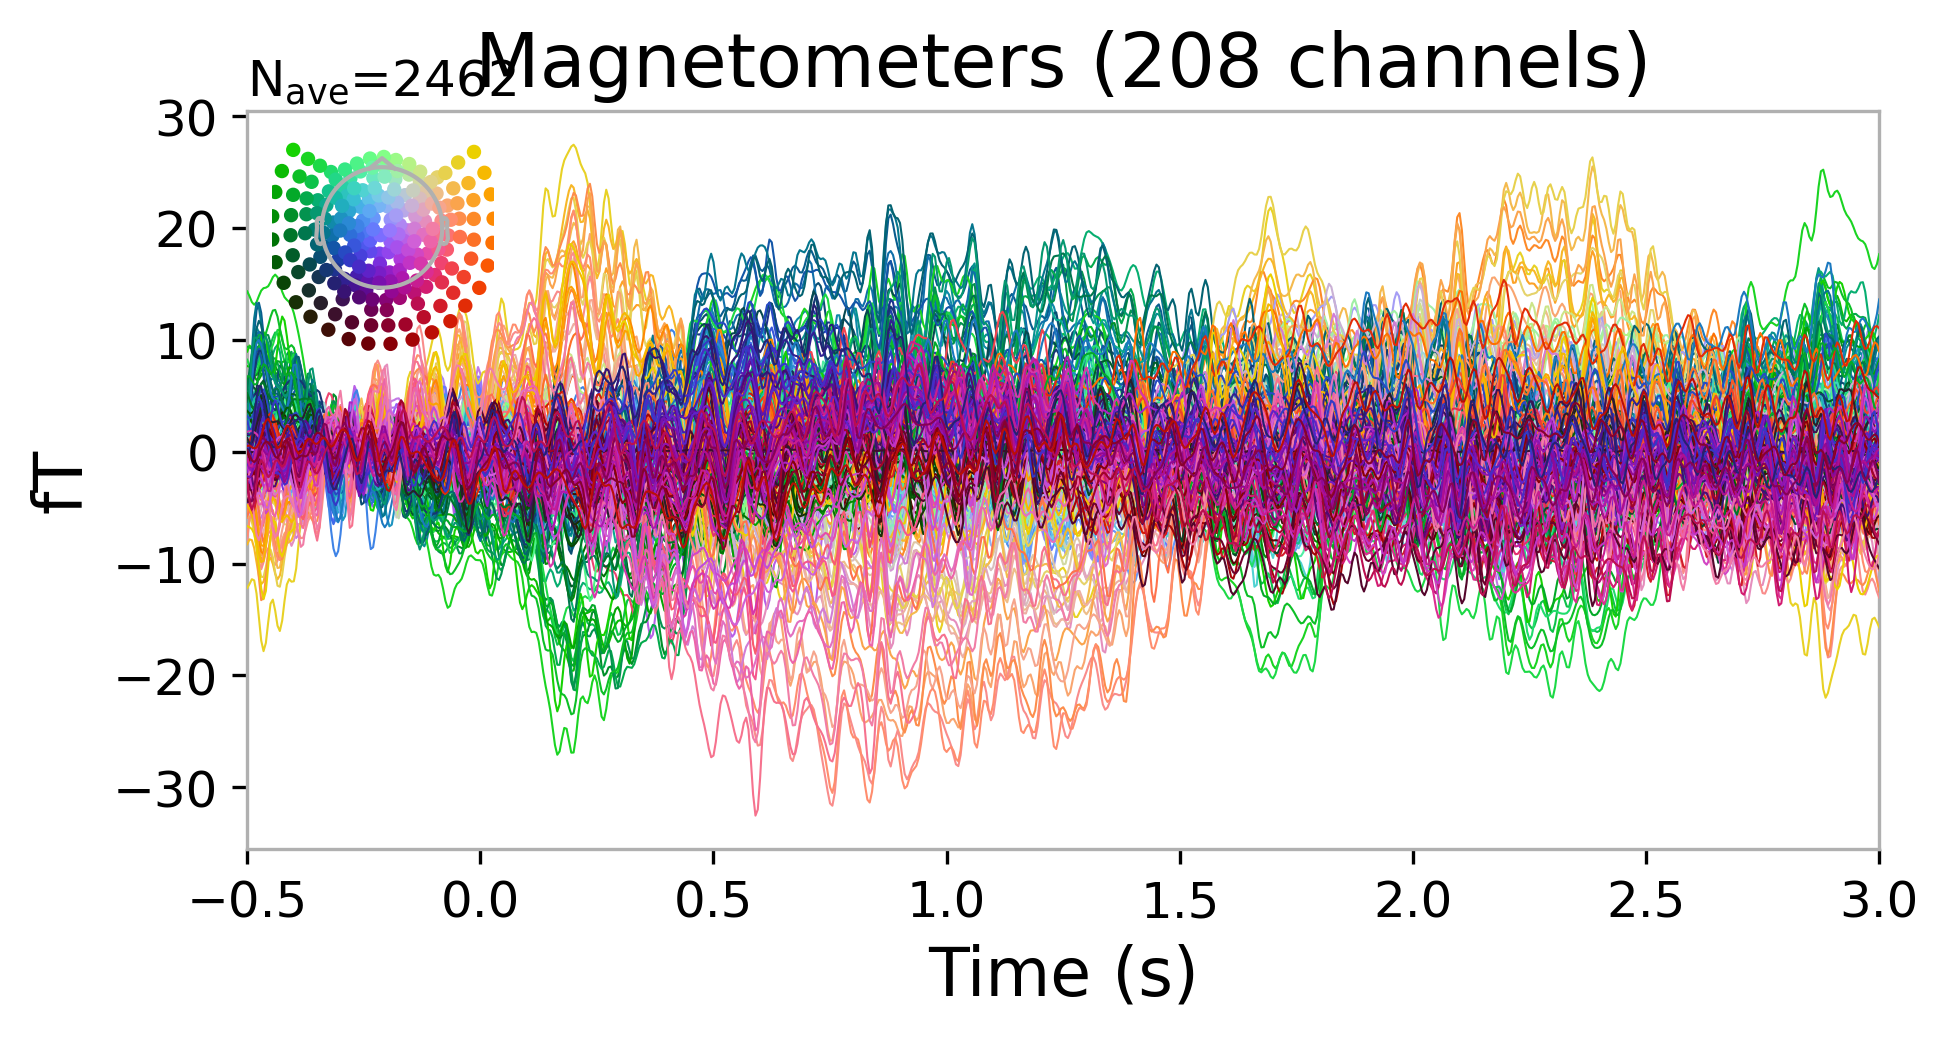

In [21]:
ph_epochs.average().plot()
plt.show()

<AxesSubplot: xlabel='s_phoneme'>

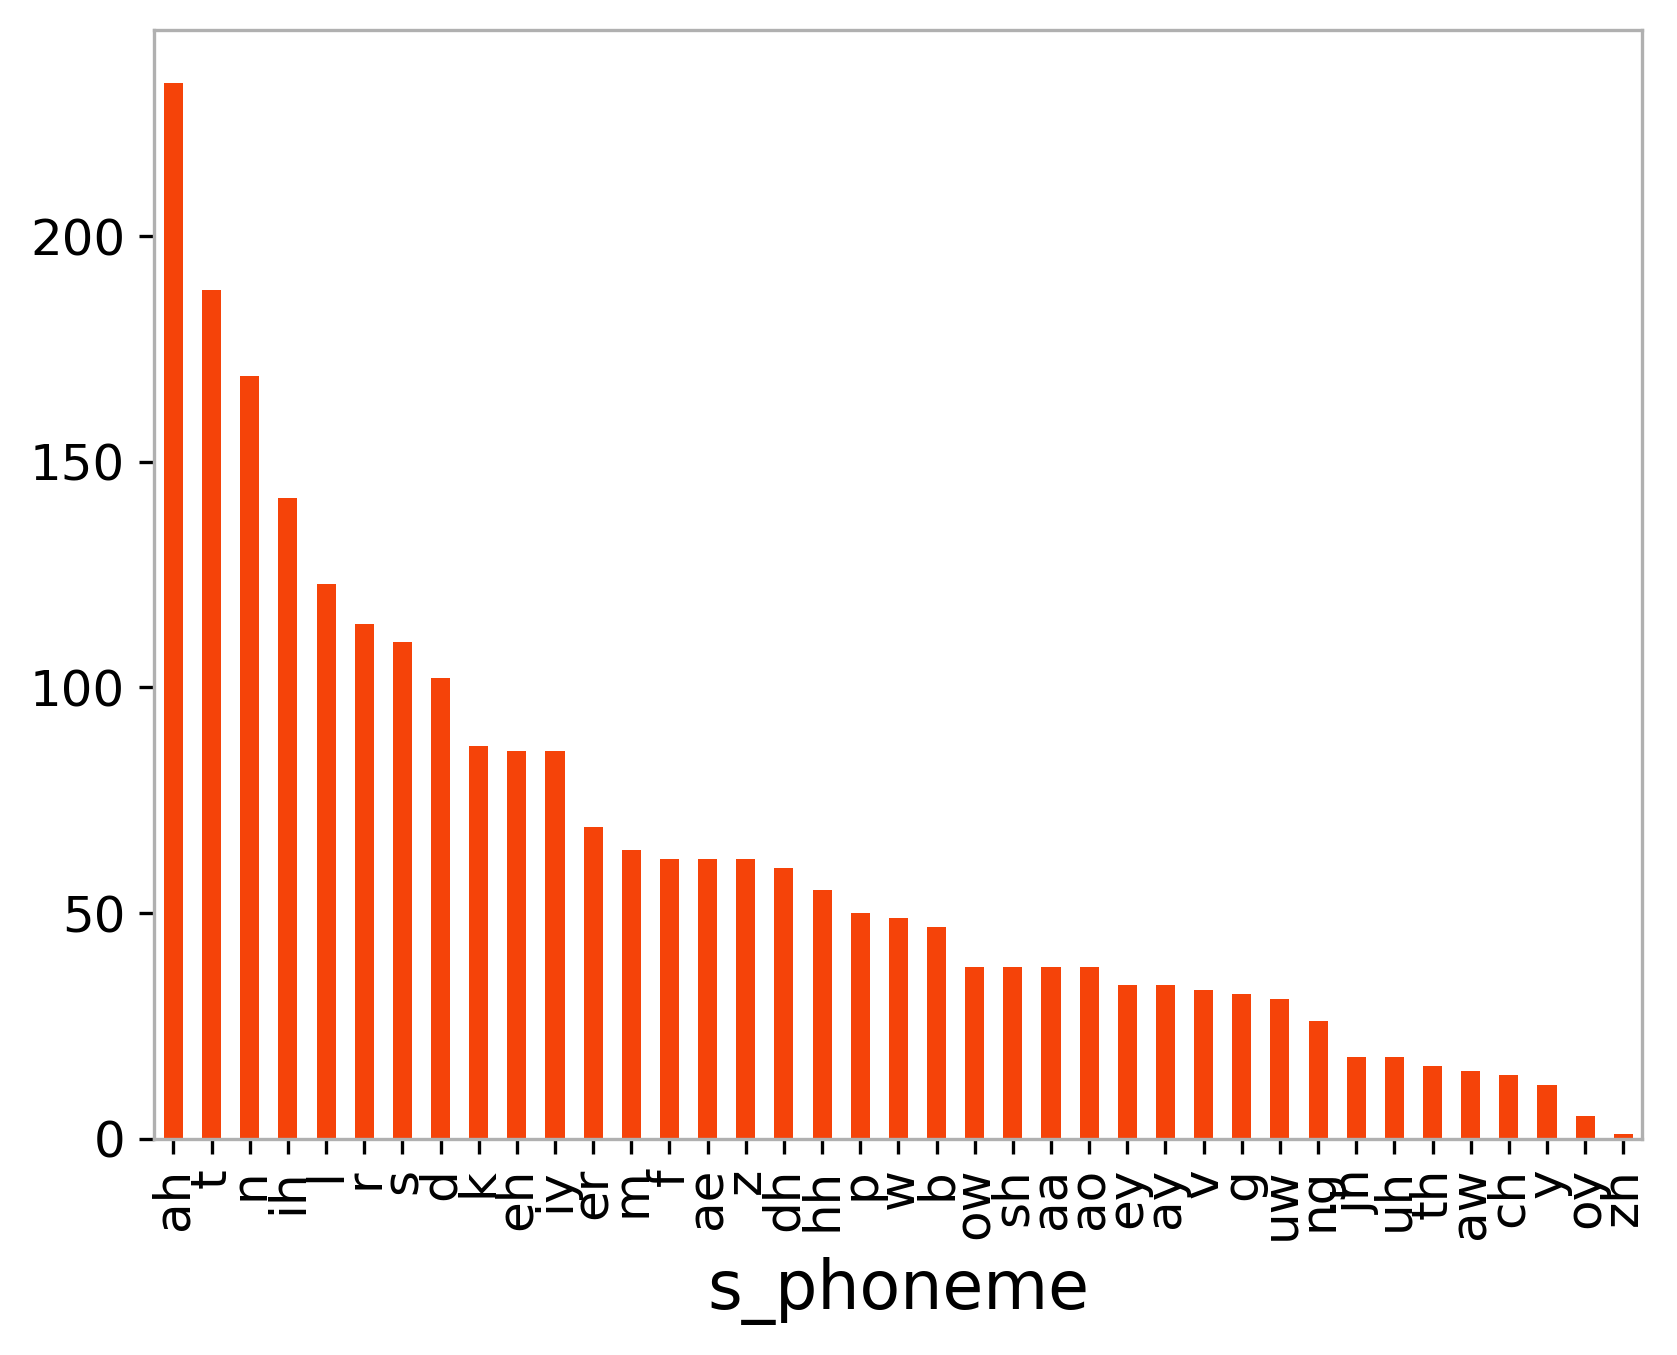

In [22]:
df.query("kind=='phoneme'").groupby("s_phoneme")["s_phoneme"].count().sort_values(ascending=False).plot.bar()

In [23]:
X = np.swapaxes(ph_epochs.get_data()[:, :208, :], 1, 2)

In [24]:
X.shape  # (n_epochs, timesteps, channels)

# 351 timesteps = 300 epoch + 51 baseline at 100Hz

(2462, 701, 208)

In [25]:
ph_epochs.info["sfreq"]

200.0

In [26]:
def tile_ph_annotations(epochs):
    
    annots = epochs.metadata
    sfreq = epochs.info["sfreq"]
    n_samples, _, n_timepts = epochs.get_data().shape
    
    y = np.ones((n_samples, n_timepts, 1), dtype=np.int32) * -1
    for i in range(n_samples):
        start_onset = float(annots.loc[i, "onset"])

        start_epoch = start_onset - P.epochs.tmin
        end_epoch = start_onset + P.epochs.tmax
        
        in_epoch_phons = annots[(annots["onset"] >= start_epoch) & (annots["onset"] <= end_epoch)]
        
        def tile(x):
            onset = round((x.onset - start_onset) * sfreq)
            steps = round(x.duration * sfreq)
            
            return (x.phoneme_code, np.arange(onset, onset+steps))
        
        indexes = in_epoch_phons.apply(tile, axis=1).values

        for val, idx in indexes:
            y[i, idx, :] = val
    
    y[np.where(y == -1)] = phoneme_list.index("sil")
    
    return y

In [27]:
y = tile_ph_annotations(ph_epochs)

In [28]:
del ph_epochs

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

n_train, time_length, n_channels = X_train.shape
n_test = X_test.shape[0]

robust_scaler = RobustScaler()  # quantile_range=(5.0, 95.0))

X_train = robust_scaler.fit_transform(X_train.reshape(-1, n_channels))
X_test = robust_scaler.transform(X_test.reshape(-1, n_channels))

th = 20
X_train = np.clip(X_train, -th, th).reshape(n_train, time_length, n_channels)
X_test = np.clip(X_test, -th, th).reshape(n_test, time_length, n_channels)

oh_encoder = OneHotEncoder(sparse_output=False)

y_train = oh_encoder.fit_transform(y_train.reshape(-1, 1)).reshape(n_train, time_length, -1)

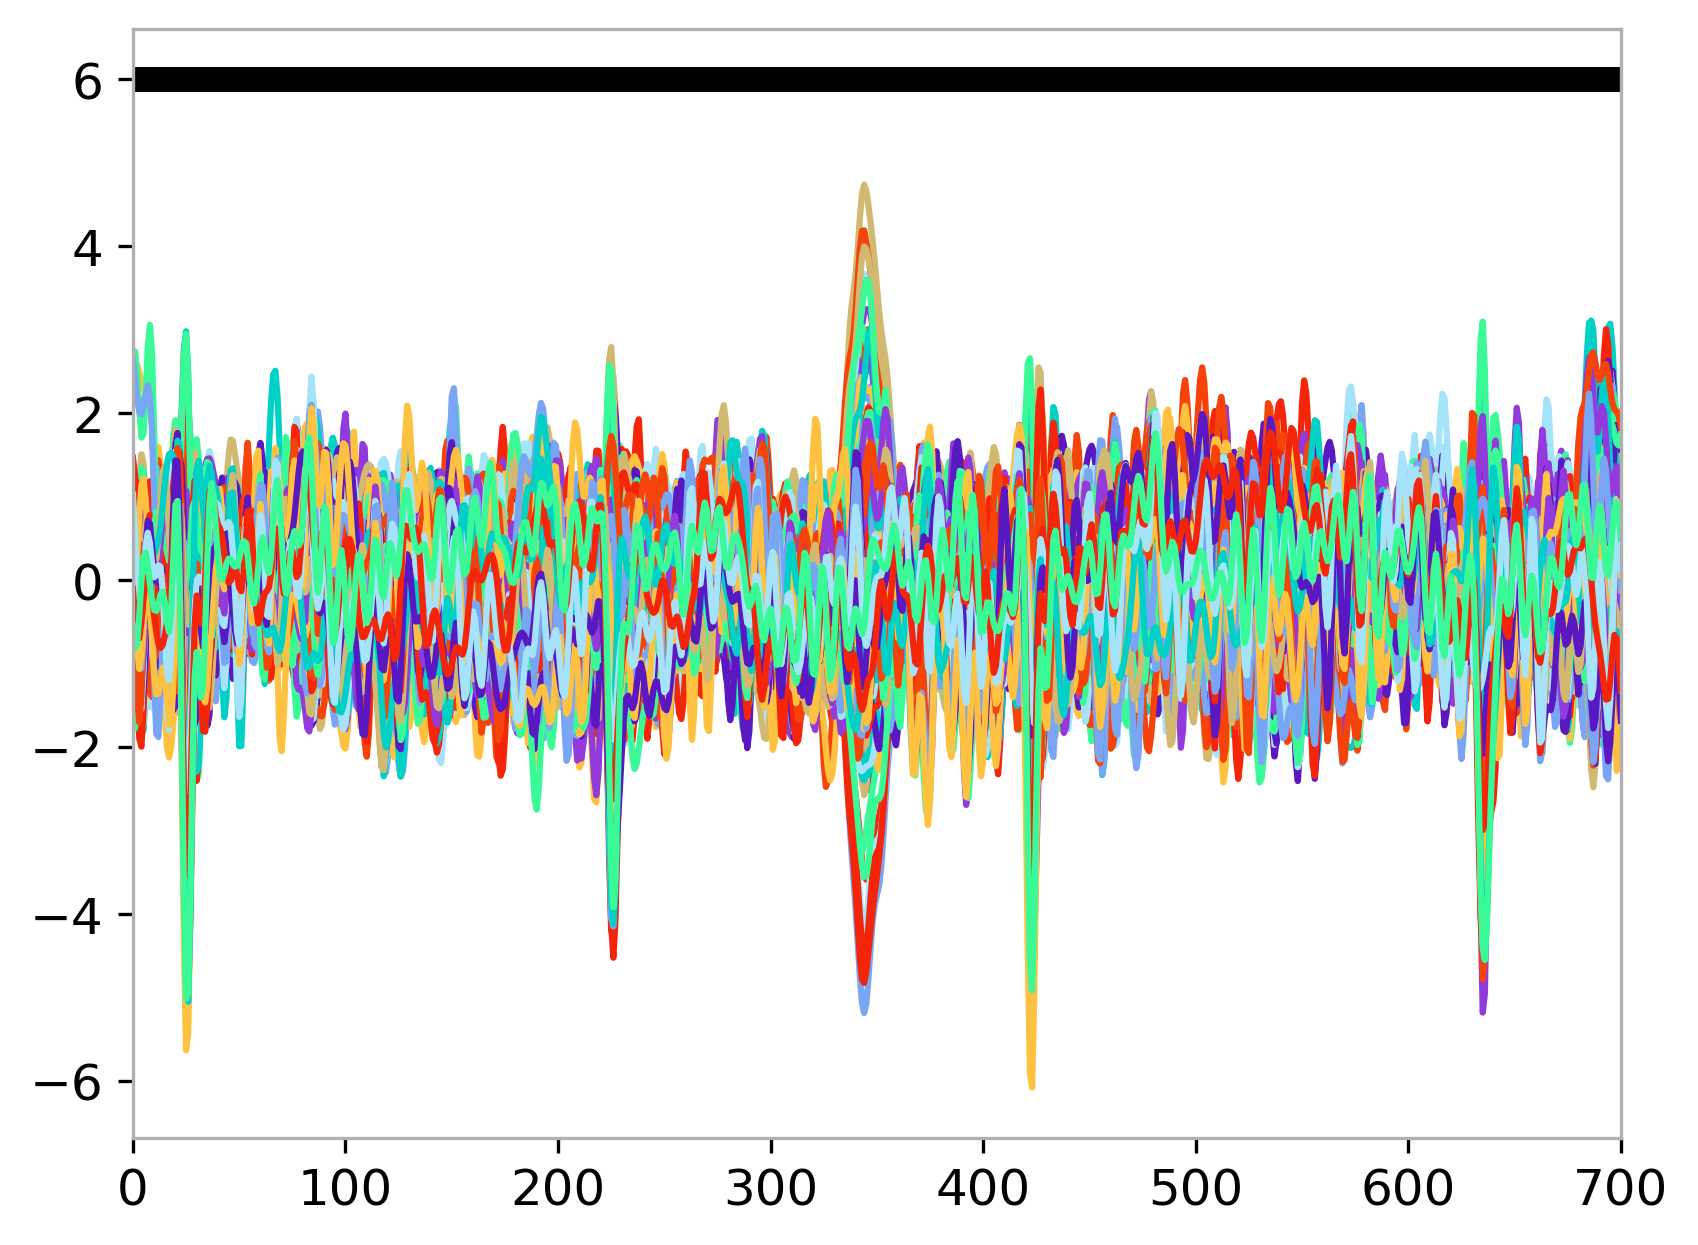

In [70]:
silence_code = 58
plt.plot(X_train[5])

for i, y_label in enumerate(y_train[5]):
    plt.scatter(i, 6, c=str(np.argmax(y_label[0]) / len(phoneme_list)), marker='|')
    
plt.show()

In [79]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

rpy.set_seed(P.seed)
rpy.verbosity(0)

0

In [80]:
reservoir = Reservoir(500, lr=0.9, sr=0.9, input_scaling=0.1)
readout = Ridge(ridge=1e-8)

esn = reservoir >> readout

In [81]:
esn.fit(X_train, y_train)

'Model-2': Model('Reservoir-2', 'Ridge-2')

In [104]:
raw_pred = esn.run(X_test)

In [105]:
y_pred = np.r_[raw_pred]

In [106]:
y_pred.shape

(247, 701, 40)

In [107]:
from sklearn.metrics import top_k_accuracy_score

top_k_accuracy_score(y_test.reshape(-1, 1), y_pred.reshape(-1, len(oh_encoder.categories_[0])), k=1)

0.5051026006803467

In [108]:
top_k_accuracy_score(y_test.reshape(-1, 1), y_pred.reshape(-1, len(oh_encoder.categories_[0])), k=10)

0.8895909256296672

In [126]:
silence_weight = (y_test != 58 * 1.0).reshape(-1)  # set silence weight to 0

In [118]:
top_k_accuracy_score(y_test.reshape(-1, 1), y_pred.reshape(-1, len(oh_encoder.categories_[0])), k=1, sample_weight=silence_weight)

0.0034704430055433923

In [124]:
top_k_accuracy_score(y_test.reshape(-1, 1), y_pred.reshape(-1, len(oh_encoder.categories_[0])), k=5, sample_weight=silence_weight)

0.5581473890156985